In [3]:
import os
import sys
import json
import glob
import h5py
import tqdm
import time
import numpy as np
import scipy.signal
import scipy.interpolate
import scipy.io
import scipy.io.wavfile
import soundfile as sf
import soxr
import matlab.engine

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [4]:
eng = matlab.engine.start_matlab();
eng.addpath('HRTFs/');


In [153]:
import importlib
import room_simulator
importlib.reload(room_simulator);


In [158]:
brir = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=45,
    src_elev=-45,
    src_dist=1.4,
    buffer_pos=0,
    sr=44100,
    dur=0.5,
    eng=eng)

brir_near = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=45,
    src_elev=45,
    src_dist=1.4,
    buffer_pos=0,
    sr=44100,
    dur=0.5,
    eng=eng)


[room simulator] head_pos: [5, 5, 5], src_pos: [5.7, 5.7, 4.010050506338834], room_dim: [10, 10, 10]
[room simulator] time elapsed: 3.113985300064087 seconds
[room simulator] incorporated 0 leading zeros
[room simulator] head_pos: [5, 5, 5], src_pos: [5.7, 5.7, 5.989949493661166], room_dim: [10, 10, 10]
[room simulator] time elapsed: 3.0809571743011475 seconds
[room simulator] incorporated 0 leading zeros


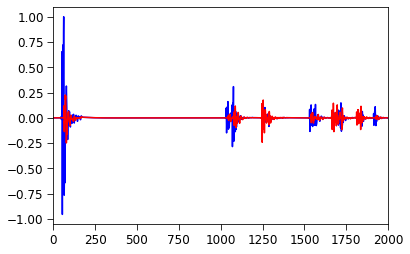

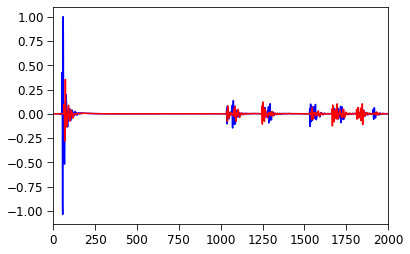

In [159]:
fig, ax = plt.subplots()
ax.plot(brir[:, 0] / brir.max(), 'b')
ax.plot(brir[:, 1] / brir.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()

fig, ax = plt.subplots()
ax.plot(brir_near[:, 0] / brir_near.max(), 'b')
ax.plot(brir_near[:, 1] / brir_near.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()


In [162]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr = sf.read(fn)
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
ipd.display(ipd.Audio(rate=sr, data=y))
print(sr, y.shape)


44100 (132300,)


In [164]:
y_spatial = util_stimuli.spatialize_sound(y, brir)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=True))

y_spatial = util_stimuli.spatialize_sound(y, brir_near)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=True))


(22050, 2) float64 (132300, 2) float64


(22050, 2) float64 (132300, 2) float64


In [165]:
import room_simulator
importlib.reload(room_simulator);

for _ in range(50):
    np.random.seed(_)
    room_parameters = room_simulator.sample_room_parameters(verbose=False)
    head_parameters = room_simulator.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer_pos = 0
    src_dist = 1.4
    for src_azim in range(0, 360, 5):
        for src_elev in range(-60, 61, 5):
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert room_simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid head position"
            assert room_simulator.is_valid_position(src_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid source position"


In [137]:
eng.quit()
